In [138]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, ShuffleSplit
import pandas as pd
import data 

sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
features = data.get_features() # uses several forms
outcomes = data.get_outcomes() # 2 outcomes: iai, and iai_intervention
df = pd.merge(features, outcomes, on='id', how='left')

100%|██████████| 49/49 [00:01<00:00, 37.04it/s]
31it [00:01, 16.49it/s]

final shape (12044, 243)


# make full data matrix

In [111]:
X_feats = data.preprocess(features)
print(X_feats.shape, X_feats.keys())

(12044, 85) Index(['id', 'ageinyrs', 'EDTriageTime_1', 'InjuryDay_1', 'InjTmKnown_1',
       'TriageTmUnkown_1', 'Certification_1', 'ThoracicTrauma_1',
       'LtCostalTender_1', 'RtCostalTender_1', 'DecrBreathSound_1',
       'AbnChestAusc_1', 'FlankTender_1', 'PelvicTender_1', 'PelvisUnstable_1',
       'NonAbdSurgery_1', 'CurrIntubated_1', 'PharmaParalyzed_1',
       'PharmaSedated_1', 'AlcDrgSuspicion_1', 'GCSEye_1', 'GCSVerbal_1',
       'GCSMotor_1', 'GCSScore_1', 'Preverbal_1', 'AbdomenPain_1',
       'ShortBreath_1', 'DistractingPain_1', 'InjuryMechanism_1',
       'AbdUltrasound_1', 'AbdCTScan_1', 'PtHosp_1', 'AbdTrauma_1',
       'SeatBeltSign_1', 'AbdDistention_1', 'BowelSounds_1', 'AbdomenTender_1',
       'PeritonIrrit_1', 'RectalBlood_1', 'InitSysBP_1', 'InitSysBPRange_1',
       'InitResp_1', 'InitRespRange_1', 'HRDocumented_1', 'InitHeartRate_1',
       'IAISuspicion_1', 'IAIAcuteInterv_1', 'LabResultAware_1', 'RefuseFU_1',
       'ChestCXR_4a', 'PelvicXR_4a', 'OthAbdIm

In [112]:
X_np = X_feats.values
feature_names = list(X_feats)
y_np = outcomes['iai_intervention']

In [113]:
# X_feats.describe()

# recreate original study

**what variables did they allow?**
- age < 2
- VomitWretch_1: Vomiting/Retching
    1. (Yes)
    2. (No)
    3. (Unknown)
    4. (Not answered)
- RecodedMOI_1: Mechanism of Injury???
    - Note - RecodedMOI reviewed / correct some "Other Mechanisms" in the InjuryMechanism_1 field
    1. Occupant in Motor Vehicle Collision (MVC)
    2. Fall from an elevation
    3. Fall down stairs
    4. Pedestrian or bicyclist struck by moving vehicle 5 - Bike collision or fall from bike while riding
    6. Motorcycle/ATV/Motorized Scooter collision
    7. Object struck abdomen
    8. Unknown mechanism
    9. Other mechanism
    10. Physician did not answer
- hypotension???
- GCSScore_1: Aggregate Glasgow Coma Score
    1. 6:Follow commands
    2. 5:Localizes pain
    3. 4:Withdraws to pain
    4. 3:Abnormal flexure posturing
    5. 2:Abnormal extension posturing 
    6. 1:None
- ThoracicTender_1
    1. Yes
    2. No
    3. Unable to Assess
    4. Physician did not answer
- evidence of thoracic wall trauma
- costal margin tenderness, decreased breath sounds
- abdominal distention
- complaints of abdominal pain
- abdominal tenderness (stratified by degree of tenderness as mild, moderate, or severe)
- evidence of abdominal wall trauma or seat belt sign
- distracting painful injury
- femur fracture

In [145]:
max_depth = 5
m = DecisionTreeClassifier(max_depth=max_depth, class_weight={0: 1, 1: 1})
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
m_cv = cross_validate(m, X_np, y_np, cv=5, scoring=['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'],
                      return_train_score=True, return_estimator=True)

In [146]:
print('metric\ttrain\ttest')
for key in m_cv:
    if 'test' in key:
        print(f"{key.replace('test_', '')}\t{np.mean(m_cv[key.replace('test', 'train')]):0.2f}\t{np.mean(m_cv[key]):0.2f}")
    

metric	train	test
precision	0.79	0.32
recall	0.31	0.19
f1	0.44	0.20
balanced_accuracy	0.65	0.59
roc_auc	0.90	0.85


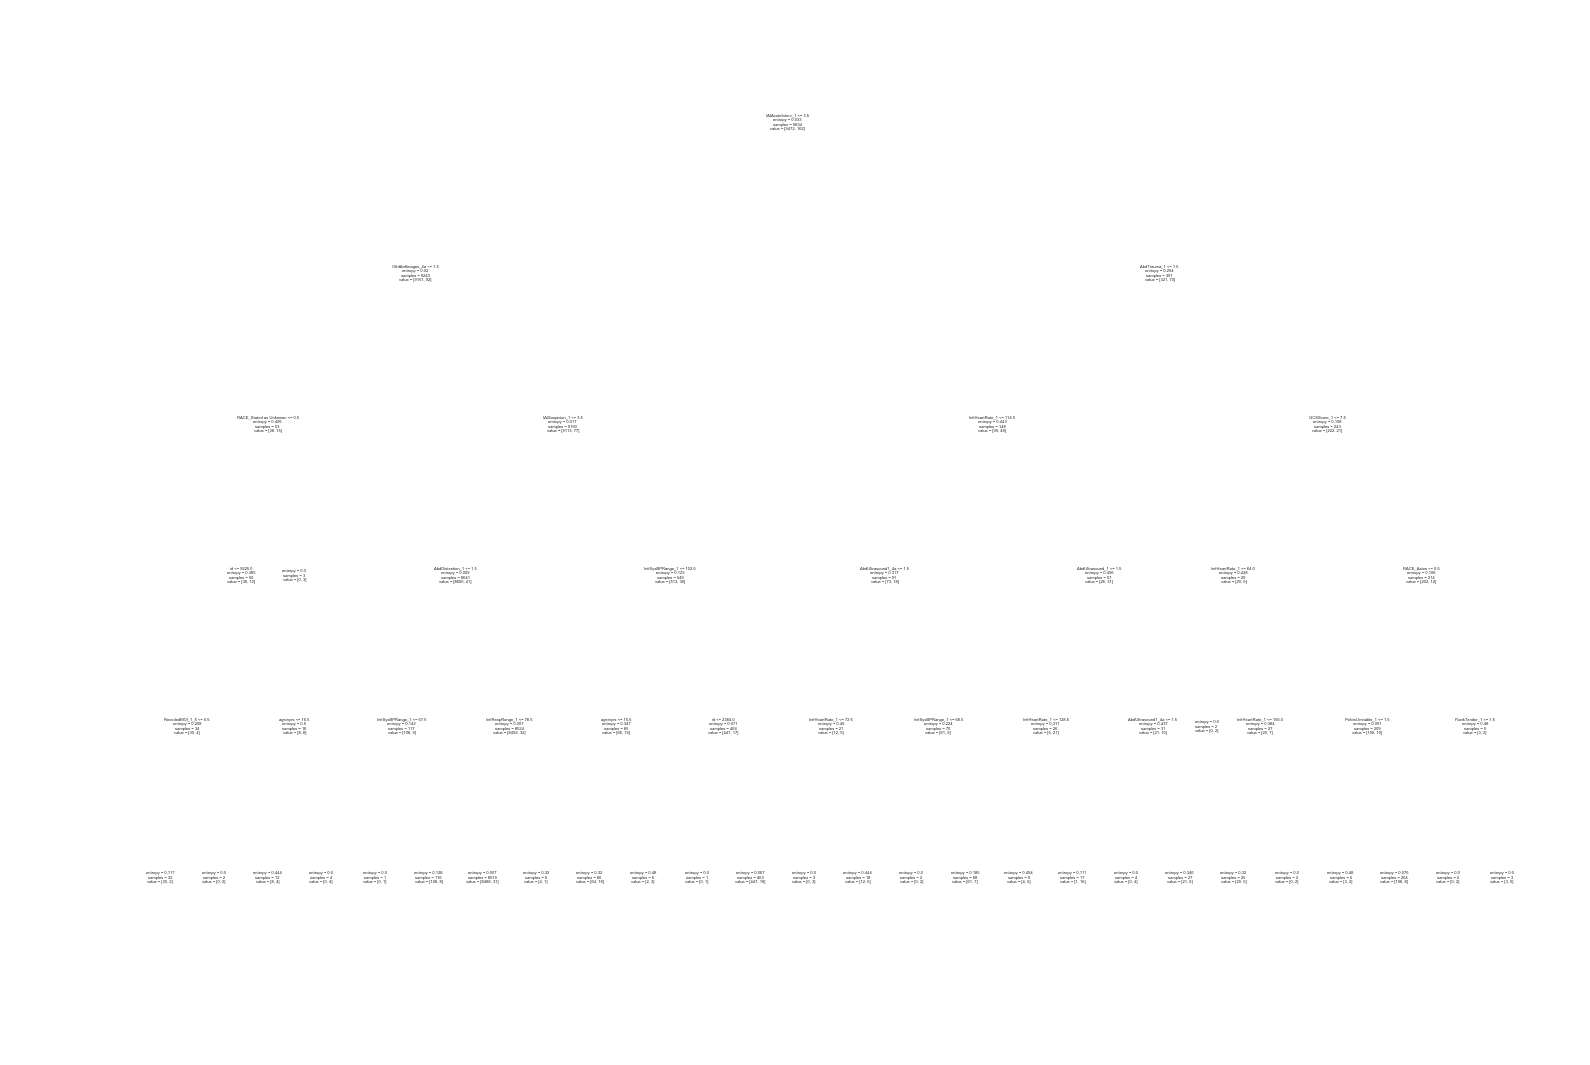

In [147]:
m_fit = m_cv['estimator'][0]
plt.figure(dpi=300)
plot_tree(m_fit, feature_names=feature_names)
plt.show()

In [118]:
# IAISuspicion_1 - Clinical suspicion for the presence of IAI identified on CT (split into 5 levels)
# IAIAcuteInterv_1 - Clinical suspicion for IAI in need of acute intervention (split into 5 levels)

In [119]:
corrs_feat = pd.merge(X_feats, outcomes, on='id', how='left').corr(method='kendall')
cs = corrs_feat.iai_intervention.sort_values(ascending=False)
cs = cs[~cs.isnull()]

# let's look at some important variables

In [120]:
print(cs[:30], cs[-30:])

iai_intervention          1.000000
IAIAcuteInterv_1          0.203900
IAISuspicion_1            0.177862
GCSEye_1                  0.135348
RefuseFU_1                0.128356
GCSMotor_1                0.124774
ThoracicTender_1_3        0.109951
GCSVerbal_1               0.103195
VomitWretch_1_3           0.096657
PeritonIrrit_1            0.094013
InitResp_1                0.075671
FlankTender_1             0.072100
PelvicTender_1            0.065348
VomitWretch_1_1           0.064815
RtCostalTender_1          0.058757
InitHeartRate_1           0.057732
LtCostalTender_1          0.049879
ShortBreath_1             0.040897
RecodedMOI_1_1            0.036576
BowelSounds_1             0.031679
RACE_Stated as Unknown    0.030409
VomitWretch_1_4           0.027779
InjTmKnown_1              0.022744
InitRespRange_1           0.021527
HISPANIC_ETHNICITY_1      0.020366
RACE_White                0.017634
RecodedMOI_1_5            0.016039
RecodedMOI_1_8            0.015373
DistractingPain_1   

In [121]:
corrs_init = df.corr(method='kendall')
cs = corrs.iai_intervention.sort_values(ascending=False)
cs = cs[~cs.isnull()]

print(cs[:30], cs[-30:])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3568: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))


iai_intervention     1.000000
OtherID_x            0.816497
Repeat_instance_y    0.469403
OtherID_x            0.436436
UltrasoundRes        0.418726
AbdMRITm             0.408248
OtherID_y            0.404301
repeat_instance_y    0.316059
UltrasoundLoc_x      0.302915
abdultrasoundday     0.284140
repeat_instance_x    0.274082
form4bctnumber       0.259460
Repeat_instance      0.246970
CTResults            0.239643
AbdUSDay             0.239083
OtherID_y            0.235702
repeat_instance_x    0.233525
repeat_instance_y    0.222480
repeat_instance_y    0.219377
PelAngioShow         0.218218
CTLocation           0.216957
repeat_instance_x    0.205207
IAIAcuteInterv       0.203900
seraltday            0.196798
repeat_instance_y    0.195825
abdctday_y           0.191299
CHCXRFindings        0.189621
OtherID_x            0.186938
SerASTDay            0.185078
SerLipaseDay         0.182777
Name: iai_intervention, dtype: float64 AbdDistention     -0.120437
AbdCTScan         -0.125014
PtHos